In [2]:
import pymongo
import math 
# import re
import pandas as pd
import numpy as np
import pylab 
from matplotlib import pyplot as plt
# from scipy import stats 
from  qgrid import show_grid as show 
from datetime import datetime

import seaborn as sns
import re
import matplotlib as mpl 
%matplotlib inline
mpl.style.use('ggplot')
data=pd.read_csv("asplos/cores_pinning.csv")


In [3]:
data.head()

,Unnamed: 0,RAPL_ENERGY_DRAM_0,RAPL_ENERGY_DRAM_0,RAPL_ENERGY_DRAM_1,RAPL_ENERGY_DRAM_1,RAPL_ENERGY_DRAM_all,RAPL_ENERGY_PKG_0,RAPL_ENERGY_PKG_0,RAPL_ENERGY_PKG_1,RAPL_ENERGY_PKG_1,...,machineName,target,time,powers_av_all,type,methode,bench,class,Nbprocess,y_ax
0,149,208.003929,NaN,47.540977,NaN,2377.742813,1477.326141,NaN,644.871765,NaN,...,50pbistest,cstates_oneCPU_CG_C_32_1,12.008,365.806587,cstates,oneCPU,CG,C,32,cstates oneCPU
1,193,194.074150,NaN,43.643890,NaN,2192.368401,1379.149872,NaN,575.500488,NaN,...,50pbistest,cstates_oneCPU_CG_C_32_2,11.007,365.394733,cstates,oneCPU,CG,C,32,cstates oneCPU
2,232,208.438087,NaN,47.768745,NaN,2368.576401,1483.594635,NaN,628.774933,NaN,...,50pbistest,cstates_oneCPU_CG_C_32_3,12.007,364.396369,cstates,oneCPU,CG,C,32,cstates oneCPU
3,275,195.843933,NaN,43.693993,NaN,2200.830162,1381.044800,NaN,580.247437,NaN,...,50pbistest,cstates_oneCPU_CG_C_32_4,11.007,366.805027,cstates,oneCPU,CG,C,32,cstates oneCPU
4,315,194.887566,NaN,43.706902,NaN,2201.859482,1381.386810,NaN,581.878204,NaN,...,50pbistest,cstates_oneCPU_CG_C_32_5,11.007,366.976580,cstates,oneCPU,CG,C,32,cstates oneCPU


In [9]:
show(data.groupby(["benchmark","mode2","mode","sensor"])["cpu"].count())

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [11]:
data.head()

,target,begin,end,sensor,cpu 0,cpu 1,dram 0,dram 1,cpu,dram,name,mode,mode2,benchmark,class,cpu number,p,number
0,normal_normal_CG_C_32_1,2019-07-23 14:01:48.978,2019-07-23 14:01:59.987,runningmodesxDahu25,1388.220093,389.906036,189.939995,43.704376,1778.126129,233.644371,normal_normal_CG_C_32_1,normal,normal,CG,C,32,1,1
1,normal_normal_CG_C_32_10,2019-07-23 14:04:02.101,2019-07-23 14:04:14.111,runningmodesxDahu25,1505.099121,407.954834,205.236259,47.758827,1913.053955,252.995087,normal_normal_CG_C_32_10,normal,normal,CG,C,32,10,10
2,normal_normal_CG_C_32_11,2019-07-23 14:04:17.116,2019-07-23 14:04:29.130,runningmodesxDahu25,1506.664886,410.537994,205.014206,47.908287,1917.202881,252.922493,normal_normal_CG_C_32_11,normal,normal,CG,C,32,11,11
3,normal_normal_CG_C_32_12,2019-07-23 14:04:32.134,2019-07-23 14:04:44.143,runningmodesxDahu25,1505.197113,420.867737,205.089470,47.746819,1926.064850,252.836288,normal_normal_CG_C_32_12,normal,normal,CG,C,32,12,12
4,normal_normal_CG_C_32_13,2019-07-23 14:04:47.148,2019-07-23 14:04:59.162,runningmodesxDahu25,1506.375427,406.829895,206.336708,47.811081,1913.205322,254.147789,normal_normal_CG_C_32_13,normal,normal,CG,C,32,13,13


In [60]:
data2=data.copy()
data2["sensor"]=data2["sensor"].apply(lambda row: "allmodesxDahu11xn2" if row == "allmodesxDahu11" else row)
data2=data2.loc[:,["target","sensor","benchmark","mode","mode2","number","cpu"]]
data2=data2.loc[data2["mode2"]!="cacheclean"]
data2["mode2"]=data2.apply(lambda row: "sleep"if row["mode"]=="sleep"else row["mode2"],axis=1)

In [61]:
show(data2)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [77]:
def cleanData(data,groupobj=["mode2","benchmark"],measure="cpu"): 
    l=pd.DataFrame()
    for j in data.groupby(groupobj): 
        dt=pd.DataFrame(j[1])
#         dt["type"]=j[0][0]
#         dt["machine Name"]=j[0][1]
        q1=dt[measure].quantile(0.25)
        q3=dt[measure].quantile(0.75)
        irq=q3-q1
        mini= q1-1.5*irq
        maxi= q3+1.5*irq
        dt=dt[((mini<=dt[measure]) & (dt[measure]<=maxi))]
        l=pd.concat([l,dt], sort=False)
    return l


In [4]:
data3.to_csv("data-running-process.csv")

NameError: name 'data3' is not defined

<Figure size 1440x720 with 0 Axes>

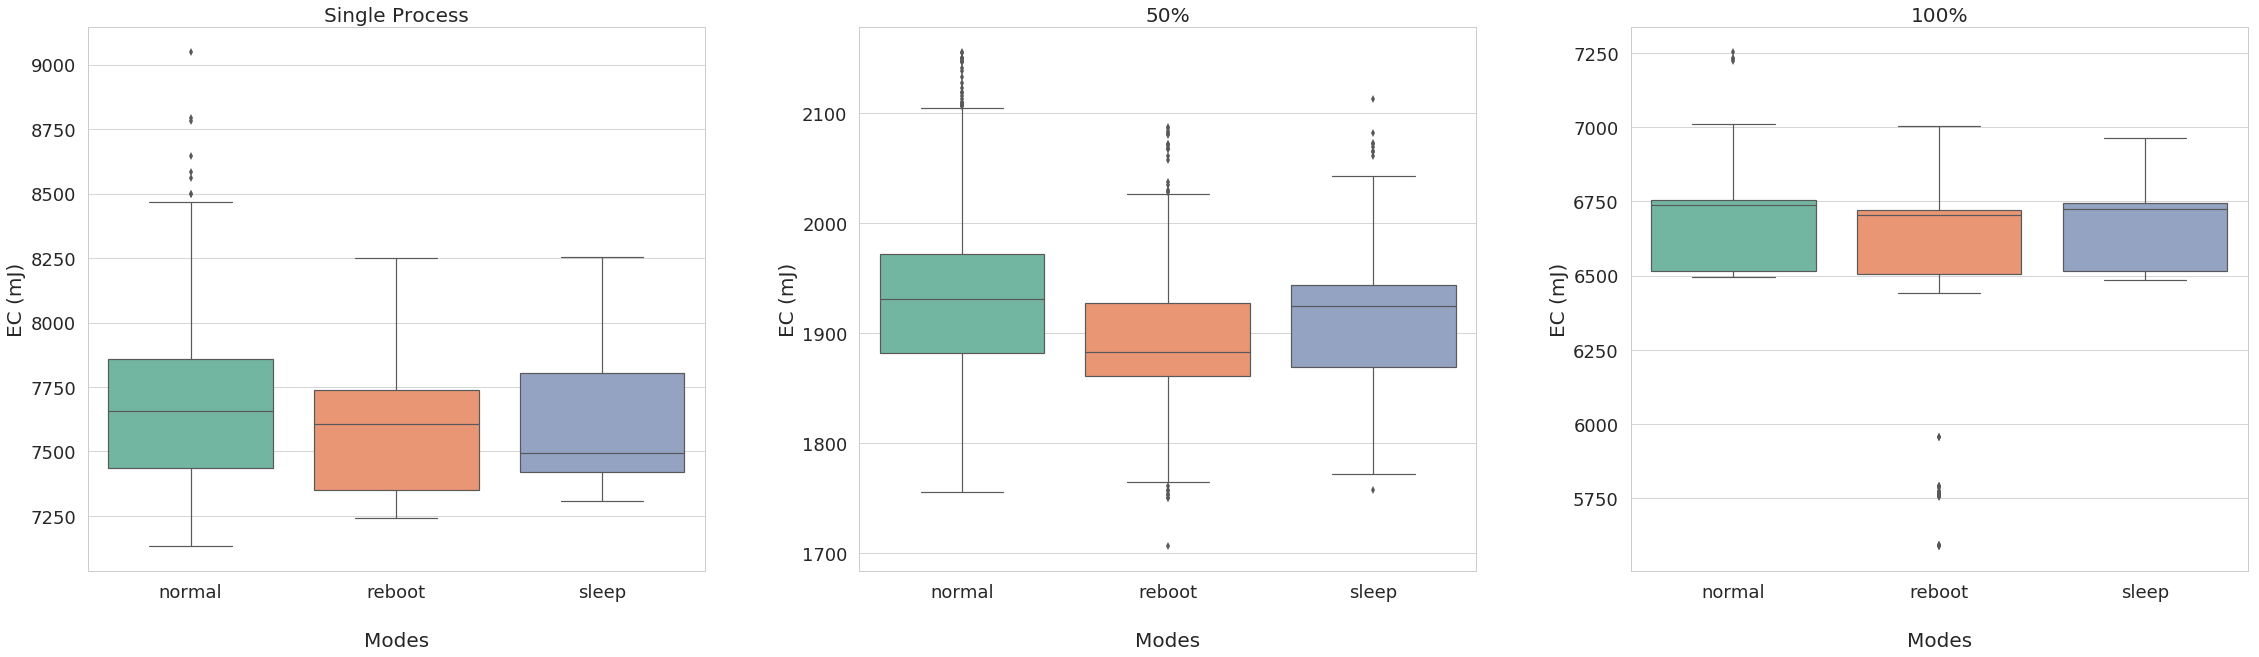

In [195]:
plt.style.use('seaborn')
sns.set_style("whitegrid") 
palette=sns.color_palette("Set2")
import matplotlib 
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['besries']
fig=plt.figure(figsize=(20,10))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20,"axes.tickarams.size":20})


# matplotlib.rc('font', **font)
# matplotlib.set(context="paper",rc=)
# pass in the font dict as kwargs
# matplotlib.rc('xlabel', labelsize=20) 
# Using seaborn's style
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
plt.subplots_adjust(wspace=0.25,left = 0,right = 1)
data3=data2.loc[np.logical_or(data2["benchmark"]!="EP",data2["cpu"]<10000)]
# .loc[data2["sensor"]=="runningmodesxDahu2"]
# Plot
fig=sns.boxplot(data=data3.loc[data3["benchmark"]=="CG"],x="mode2",y="cpu",palette=palette,ax=axes[1])
fig.set_ylabel(ylabel="EC (mJ)")
fig.set_xlabel(xlabel="Modes",labelpad=30)
fig.set_title("50%" )
fig.tick_params(labelsize=18)
fig=sns.boxplot(data=data3.loc[data3["benchmark"]=="LU"],x="mode2",y="cpu",palette=palette,ax=axes[2])
fig.set_ylabel(ylabel="EC (mJ)")
fig.set_xlabel(xlabel="Modes",labelpad=30)
fig.set_title("100%" )
fig.tick_params(labelsize=18)
fig=sns.boxplot(data=data3.loc[data3["benchmark"]=="EP"],x="mode2",y="cpu",palette=palette,ax=axes[0])
fig.set_ylabel(ylabel="EC (mJ)")
fig.set_xlabel(xlabel="Modes",labelpad=30)
fig.set_title("Single Process")
fig.tick_params(labelsize=18)
## adjust lines 
plt.savefig("running-process.pdf",format="pdf")

In [177]:
def bootstrap(energy,groupbyobj="mode2",sampleSize=40): 
    l=[(energy.loc[energy[groupbyobj]==x ],x) for x in energy[groupbyobj].drop_duplicates() ]
#     l=[np.random.choice(x["cpu"], size=(5000, sampleSize))for x in l]
#     return l
    l=[(np.random.choice(i["cpu"], size=(5000, sampleSize)),j) for i,j in l ]
    l=[(np.std(i,1),j) for i,j in l]
    l2=[]
    for i,j in l:
        data=pd.DataFrame()
        data["val"]=i
        data[groupbyobj]=j
        l2.append(data)
    return l,pd.concat(l2)


energylu=data2.loc[data2["benchmark"]=="LU"]
e3,_=bootstrap(energylu)
e4,_=bootstrap(data3.loc[data2["benchmark"]=="LU"])

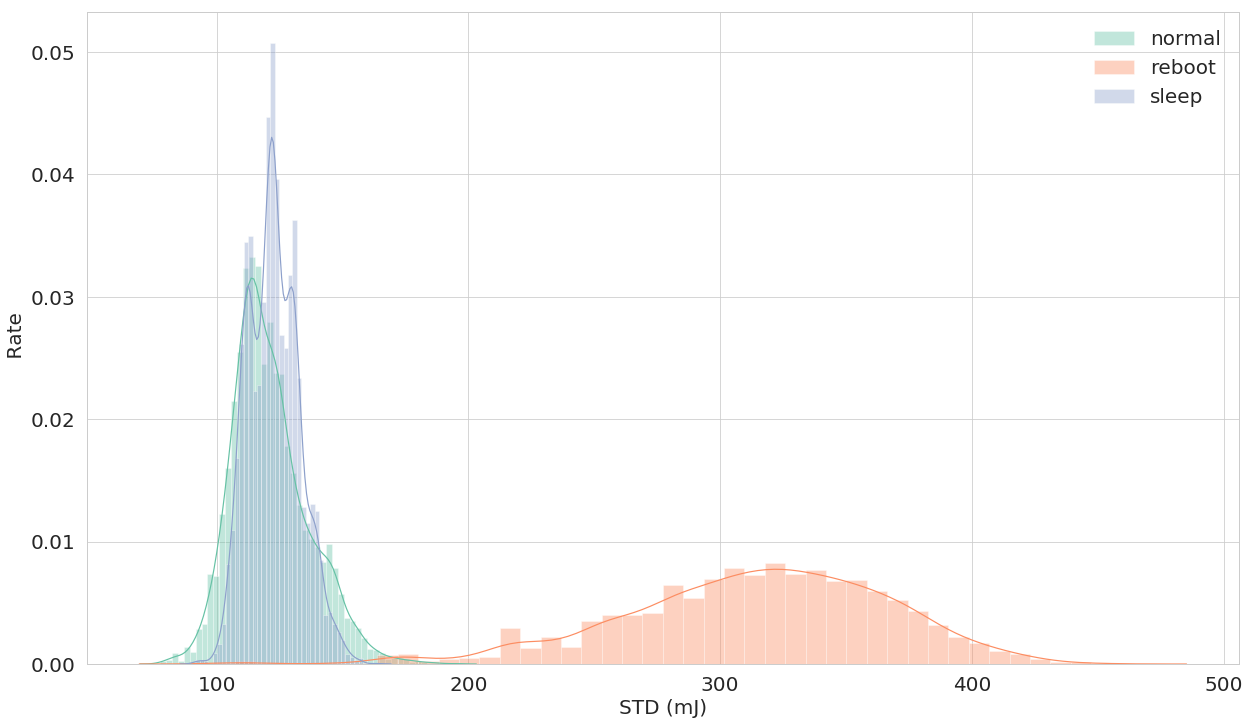

In [226]:

fig = plt.figure(figsize=(20,12))
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20,"axes.tickarams.size":20})
plt.subplots_adjust(left = 0.1,right = 0.9)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.set_style("whitegrid")
colors={"normal":palette[0],"reboot":palette[1],"sleep":palette[2]}
for i,j in e3: 
    fig=sns.distplot(i,label=j,color=colors[j])
fig.legend(fontsize=20,)
fig.set_xlabel(xlabel="STD (mJ)")
fig.set_ylabel(ylabel=" Rate")
plt.savefig("reboot.png",format="pdf")

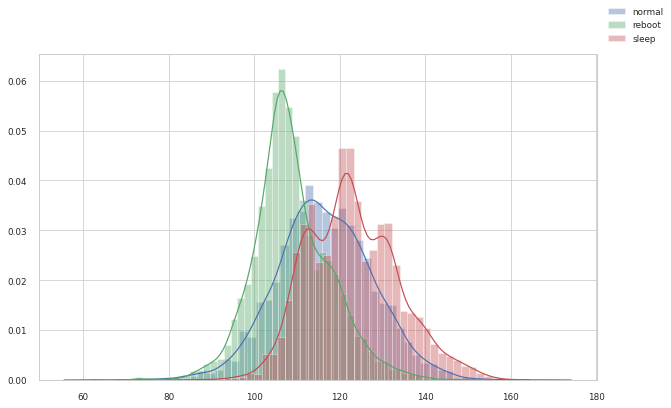

In [178]:
fig = plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
legends=[]
for i,j in e4: 
    sns.distplot(i,label=j)
    legends.append(j)
fig.legend(labels=legends)

plt.show()